# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

# (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [38]:
import torch
import os
import cv2 
import torchvision 
from torchvision import datasets, transforms ,models 
import numpy as np 
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim 
import torch.nn as nn  
import torch.nn.functional as F 
from PIL import Image 
import matplotlib.pyplot as plt 
%matplotlib inline 


In [39]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

valid_size = 0.2   #validation size 

#dataloader parameters
batch_size  = 50
num_workers = 0

#directories for training and test data
data_dir  = '/data/landmark_images/'
train_dir = os.path.join(data_dir,'train') 
test_dir  = os.path.join(data_dir,'test') 

# load and transform data 
data_transform = transforms.Compose([transforms.Resize(32),transforms.CenterCrop(32),transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)

# split indices into valid_indices and train_indices  
train_data_len = len(train_data)
train_data_indices = list(range(train_data_len))
np.random.shuffle(train_data_indices)
valid_indices,train_indices = np.split(train_data_indices, [int(train_data_len*valid_size)])

# use samplers for training and validation batches
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

#data loaders
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)

loaders_scratch = {'train': None, 'valid': None, 'test': None}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: I followed the lectures to write the code , These Images is larger than what is usually used in lecture , but I choose to go with what I learned and check the result .
I don’t use rotating because the images are landscapes so most of them are taken in landscape mode therefore don’t see the need to rotating the images .however , I resized and cropped the images to 32 pixels and normalized the images for printing  . 


### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

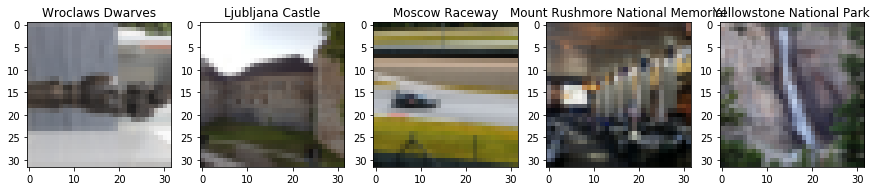

In [40]:
## TODO: visualize a batch of the train data loader
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

classes = [item[3:].replace("_", " ") for item in train_data.classes] # list the class names by index 


dataiter = iter(train_loader) #access images 
images, labels = dataiter.next()
images = images.numpy()  #for display change to numpy 

#plot and label the images 
fig = plt.figure()
fig.set_size_inches(15, 15)
for i in np.arange(5):
    ax = fig.add_subplot(1, 5, i+1)
    plt.imshow(np.transpose(images[i]/2+0.5, (1, 2, 0)))#unnormalize 
    ax.set_title(classes[labels[i]])


### Initialize use_cuda variable

In [41]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [42]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss() 

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [43]:
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1) 
        
        self.pool  = nn.MaxPool2d(2, 2)                      
        
        self.fc1   = nn.Linear(64 * 4 * 4, 500)        
        
        self.fc2   = nn.Linear(500, 50)                
        
        self.dropout = nn.Dropout(0.25)              

    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))        
        
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x)))        
        
        x = x.view(-1, 64 * 4 * 4)                          
        
        x = self.dropout(x)                                
        
        x = F.relu(self.fc1(x))                             
        
        x = self.dropout(x)                                  
        
        x = self.fc2(x)                              
       
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    

In [44]:
#model_scratch

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
I used the network from the lectures and it went well ,and i follow this : https://web.stanford.edu/class/cs379c/archive/2018/class_messages_listing/content/Artificial_Neural_Network_Technology_Tutorials/KarparthyCONVOLUTIONAL-NEURAL-NETWORKS-16.pdf

The most common form of a ConvNet is: 
INPUT -> [[CONV -> RELU] N -> POOL?] M -> [FC -> RELU] * K -> FC

The used in the parameters are :
N=1 (N>=0 and N <=3)  ,
M=3 (M>= 0)   ,
K=1 (K>=0 and K<3)  .

The final Network looks like this:
INPUT -> [[CONV -> RELU] 1 -> POOL] 3 -> [FC -> RELU] * 1 -> FC


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [45]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate (train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            optimizer.zero_grad()                      
            output = model(data)                       
            loss = criterion(output, target)             
            loss.backward()                             
            optimizer.step()                             
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss)) 
       
    
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        
        model.eval()
        for batch_idx, (data, target) in enumerate (valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
           ## TODO: update average validation loss
           
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model


### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [46]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy

    
    classname = m.__class__.__name__ 
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)   
    

#-#-# Do NOT modify the code below this line. #-#-#

model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),criterion_scratch, use_cuda, 
                    'ignore.pt')

Epoch: 1 	Training Loss: 17.620084 	Validation Loss: 3.915646
Validation loss decreased (inf --> 3.915646).  Saving model ...
Epoch: 2 	Training Loss: 3.916544 	Validation Loss: 3.915776
Epoch: 3 	Training Loss: 3.914320 	Validation Loss: 3.915332
Validation loss decreased (3.915646 --> 3.915332).  Saving model ...
Epoch: 4 	Training Loss: 3.913590 	Validation Loss: 3.915778
Epoch: 5 	Training Loss: 3.913014 	Validation Loss: 3.915980
Epoch: 6 	Training Loss: 3.912442 	Validation Loss: 3.916380
Epoch: 7 	Training Loss: 3.912244 	Validation Loss: 3.916841
Epoch: 8 	Training Loss: 3.912183 	Validation Loss: 3.916920
Epoch: 9 	Training Loss: 3.912277 	Validation Loss: 3.917024
Epoch: 10 	Training Loss: 3.912100 	Validation Loss: 3.917034
Epoch: 11 	Training Loss: 3.911748 	Validation Loss: 3.917549
Epoch: 12 	Training Loss: 3.911986 	Validation Loss: 3.917649
Epoch: 13 	Training Loss: 3.911683 	Validation Loss: 3.917787
Epoch: 14 	Training Loss: 3.911818 	Validation Loss: 3.917652
Epoch: 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [47]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                     criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.834349 	Validation Loss: 3.708642
Validation loss decreased (inf --> 3.708642).  Saving model ...
Epoch: 2 	Training Loss: 3.582409 	Validation Loss: 3.545830
Validation loss decreased (3.708642 --> 3.545830).  Saving model ...
Epoch: 3 	Training Loss: 3.386565 	Validation Loss: 3.412822
Validation loss decreased (3.545830 --> 3.412822).  Saving model ...
Epoch: 4 	Training Loss: 3.207184 	Validation Loss: 3.306053
Validation loss decreased (3.412822 --> 3.306053).  Saving model ...
Epoch: 5 	Training Loss: 3.042464 	Validation Loss: 3.227146
Validation loss decreased (3.306053 --> 3.227146).  Saving model ...
Epoch: 6 	Training Loss: 2.890048 	Validation Loss: 3.099085
Validation loss decreased (3.227146 --> 3.099085).  Saving model ...
Epoch: 7 	Training Loss: 2.687619 	Validation Loss: 3.048494
Validation loss decreased (3.099085 --> 3.048494).  Saving model ...
Epoch: 8 	Training Loss: 2.519547 	Validation Loss: 3.014048
Validation loss decreased (3.04849

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [48]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.827934


Test Accuracy: 29% (364/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [49]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_transform = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=data_transform)


train_data_len = len(train_data)
train_data_indices = list(range(train_data_len)) 
np.random.shuffle(train_data_indices)
valid_indices,train_indices = np.split(train_data_indices, [int(train_data_len*valid_size)])


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)


train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)
loaders_transfer = {'train': None, 'valid': None, 'test': None}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [50]:
## TODO: select loss function
criterion_transfer =nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer

    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)
    
    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [51]:

## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()
    

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I follow the vgg16 network from lectures ,first lock the features parameters because we don’t to change it , we want to optimize it to match the classes, the last layer is changed , the same number of inputs ,but we want the output to match our classes  , and i follow this : https://web.stanford.edu/class/cs379c/archive/2018/class_messages_listing/content/Artificial_Neural_Network_Technology_Tutorials/KarparthyCONVOLUTIONAL-NEURAL-NETWORKS-16.pdf

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [52]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

# number of epochs to train the model
num_epochs = 10

model_scratch = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
         
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.830990 	Validation Loss: 3.569330
Validation loss decreased (inf --> 3.569330).  Saving model ...
Epoch: 2 	Training Loss: 3.457518 	Validation Loss: 3.243818
Validation loss decreased (3.569330 --> 3.243818).  Saving model ...
Epoch: 3 	Training Loss: 3.149932 	Validation Loss: 2.953025
Validation loss decreased (3.243818 --> 2.953025).  Saving model ...
Epoch: 4 	Training Loss: 2.855378 	Validation Loss: 2.690334
Validation loss decreased (2.953025 --> 2.690334).  Saving model ...
Epoch: 5 	Training Loss: 2.615718 	Validation Loss: 2.452189
Validation loss decreased (2.690334 --> 2.452189).  Saving model ...
Epoch: 6 	Training Loss: 2.396083 	Validation Loss: 2.242563
Validation loss decreased (2.452189 --> 2.242563).  Saving model ...
Epoch: 7 	Training Loss: 2.204776 	Validation Loss: 2.066752
Validation loss decreased (2.242563 --> 2.066752).  Saving model ...
Epoch: 8 	Training Loss: 2.040551 	Validation Loss: 1.919751
Validation loss decreased (2.06675

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [53]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.621869


Test Accuracy: 63% (797/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [54]:

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)
    img = data_transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    # get k best predictions 
    output = model_transfer(img)
    _, preds_tensor = torch.topk(output,k)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    # creat an array with all the possible classes we found
    name =[]
    for pred in preds:
        name.append(classes[pred])
    
    return name

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Eiffel Tower']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

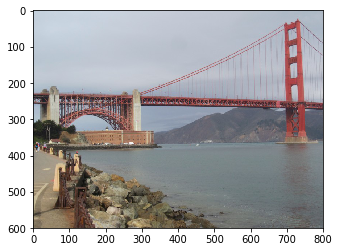

Is this pciture of the
Golden Gate Bridge, Forth Bridge, or Brooklyn Bridge?


In [55]:
from PIL import Image
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('Is this pciture of the')
    print('%s, %s, or %s?' % (predicted_landmarks[0], predicted_landmarks[1],predicted_landmarks[2]))

    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
The output it’s better then what I expected 
For improvement : 
- more training
- more images for training
- use more complex Network ( e.g., ResNet)


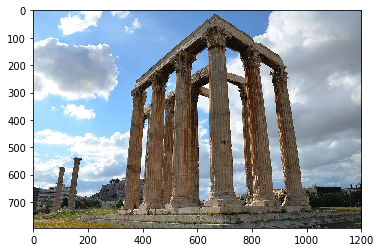

Is this pciture of the
Temple of Olympian Zeus, Gateway of India, or Pont du Gard?


In [56]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
## images from wikipedia
suggest_locations('images/L/TempleofZeus.jpg')


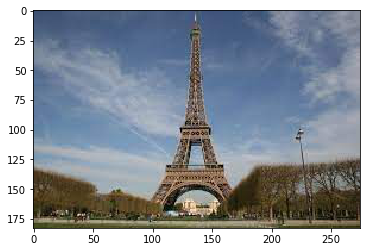

Is this pciture of the
Vienna City Hall, Eiffel Tower, or Terminal Tower?


In [57]:
suggest_locations('images/L/EiffelTower.jpg')


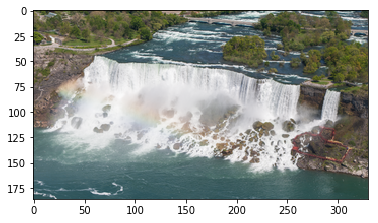

Is this pciture of the
Niagara Falls, Banff National Park, or Gullfoss Falls?


In [58]:
suggest_locations('images/L/NiagaraFalls.png')

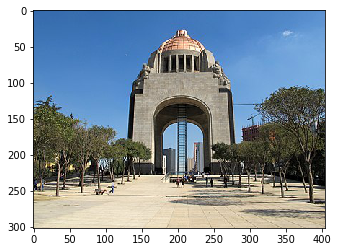

Is this pciture of the
Monumento a la Revolucion, Gateway of India, or Stockholm City Hall?


In [59]:
suggest_locations('images/L/MonumentoalaRevolución.jpg')